In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing = training_set.isnull().any()
print(any_missing)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)






V2    False
dtype: bool
all training set length:  48000


In [2]:
train_set=training_set[:44600]
print(train_set.shape)

(44600, 1)


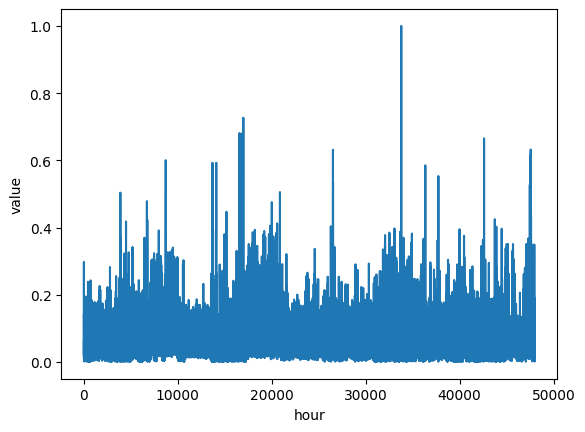

In [3]:
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(training_set)
plt.show()

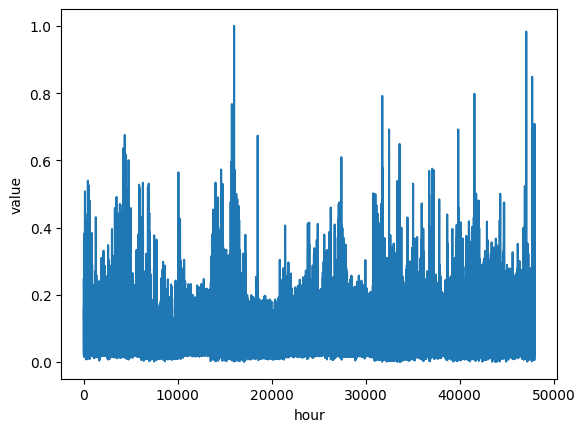

In [4]:
test_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

test_set = test_set.iloc[:,1:2].values
sc = MinMaxScaler()
test_set = sc.fit_transform(test_set)
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(test_set)
plt.show()

In [5]:

seq_length = 256 #it is tau in the paper
x, y = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x))
print(trainX.shape)
size=trainX.size(0)


torch.Size([44343, 256, 1])


In [6]:
sequences=utils.real_seq(training_set,seq_length)
sequences=sequences[:size]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)

float64
torch.Size([44343, 1, 256])


# *TRAIN*

In [7]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

In [8]:

path="Models/M4"
utils.create_folder(path)


The new models directory is created!


In [9]:
%%time

embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1

#extract the number of features
num_features=trainX.size(2)+10

#Hyperparameters
batch_size=379
discriminator_lr=0.00005
generator_lr=0.00005
num_epochs=100
criterion = nn.MSELoss()
save = True
gpu = True



device=utils.assign_device(gpu)

#Initializations
train = TensorDataset(trainX, sequences)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False) 


D=progressive_blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,device)
G=progressive_blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,device)
optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))

blocks_to_add=2
activeG=(G.step-1)-blocks_to_add
activeD=blocks_to_add
timestamp=15
fade=1/num_epochs

#Training
g_losses = []
d_losses = []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
        g_loss_min=0.30
        d_loss_min=0.6
        g_losses_temp=[]
        d_losses_temp=[]

        if (epoch%timestamp==0 and epoch!=0 and activeG!=G.step-1 and activeD!=0):
                activeG+=1
                activeD-=1

        for i, (X, Y) in enumerate((train_loader)):
            
            X=X.to(device)
            Y=Y.to(device)
            # Generate fake data
            
            fake_data = G(X,fade,activeG)
            #print(fake_data.shape)
           
            # Train the discriminator
            Y=Y[:,:,:fake_data.size(2)]  #we use this to adapt real sequences length to fake sequences length
           
            D.zero_grad()
            d_real_loss = criterion(D(Y,X,fade,activeD), torch.ones_like(D(Y,X,fade,activeD)))
            d_fake_loss = criterion(D(fake_data.detach(),X,fade,activeD), torch.zeros_like(D(fake_data.detach(),X,fade,activeD)))
            d_loss = d_real_loss + d_fake_loss
            d_losses_temp.append(d_loss.item())
            d_loss.backward(retain_graph=False)
            optimD.step()
            
            # Train the generator
            G.zero_grad()
            g_loss = criterion(D(fake_data,X,fade,activeD), torch.ones_like(D(fake_data,X,fade,activeD)))

            # Add the moment loss
            g_loss += moment_loss(fake_data, Y)
            #g_loss = moment_loss(fake_data, Y)
            g_losses_temp.append(g_loss.item())

            if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                g_loss_min = g_loss
                d_loss_min = d_loss
                torch.save(G.state_dict(), path+'/generator.pt')
                torch.save(G, path+'/generator_model.pt')
                torch.save(D.state_dict(), path+'/discriminator.pt')
                torch.save(D, path+'/discriminator_model.pt')
                print('Improvement-Detected, model saved')

            g_loss.backward()
            optimG.step()
            
            fade+=1/num_epochs

            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
                    (epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))
        g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
        d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))

Cuda enabled: using GPU
[Epoch 1/100] [Batch 1/117] [D loss: 1.632112] [G loss: 1.764682]
[Epoch 1/100] [Batch 2/117] [D loss: 1.632460] [G loss: 1.756891]
[Epoch 1/100] [Batch 3/117] [D loss: 1.632354] [G loss: 1.748547]
[Epoch 1/100] [Batch 4/117] [D loss: 1.632194] [G loss: 1.720486]
[Epoch 1/100] [Batch 5/117] [D loss: 1.632017] [G loss: 1.729521]
[Epoch 1/100] [Batch 6/117] [D loss: 1.631837] [G loss: 1.723223]
[Epoch 1/100] [Batch 7/117] [D loss: 1.631657] [G loss: 1.701804]
[Epoch 1/100] [Batch 8/117] [D loss: 1.631477] [G loss: 1.710756]
[Epoch 1/100] [Batch 9/117] [D loss: 1.631297] [G loss: 1.693959]
[Epoch 1/100] [Batch 10/117] [D loss: 1.631116] [G loss: 1.675447]
[Epoch 1/100] [Batch 11/117] [D loss: 1.630937] [G loss: 1.705127]
[Epoch 1/100] [Batch 12/117] [D loss: 1.630757] [G loss: 1.689379]
[Epoch 1/100] [Batch 13/117] [D loss: 1.630577] [G loss: 1.658966]
[Epoch 1/100] [Batch 14/117] [D loss: 1.630395] [G loss: 1.650443]
[Epoch 1/100] [Batch 15/117] [D loss: 1.630215]

End-training Generator Loss: tensor(0.3058)
End-training Discriminator Loss: tensor(0.4736)


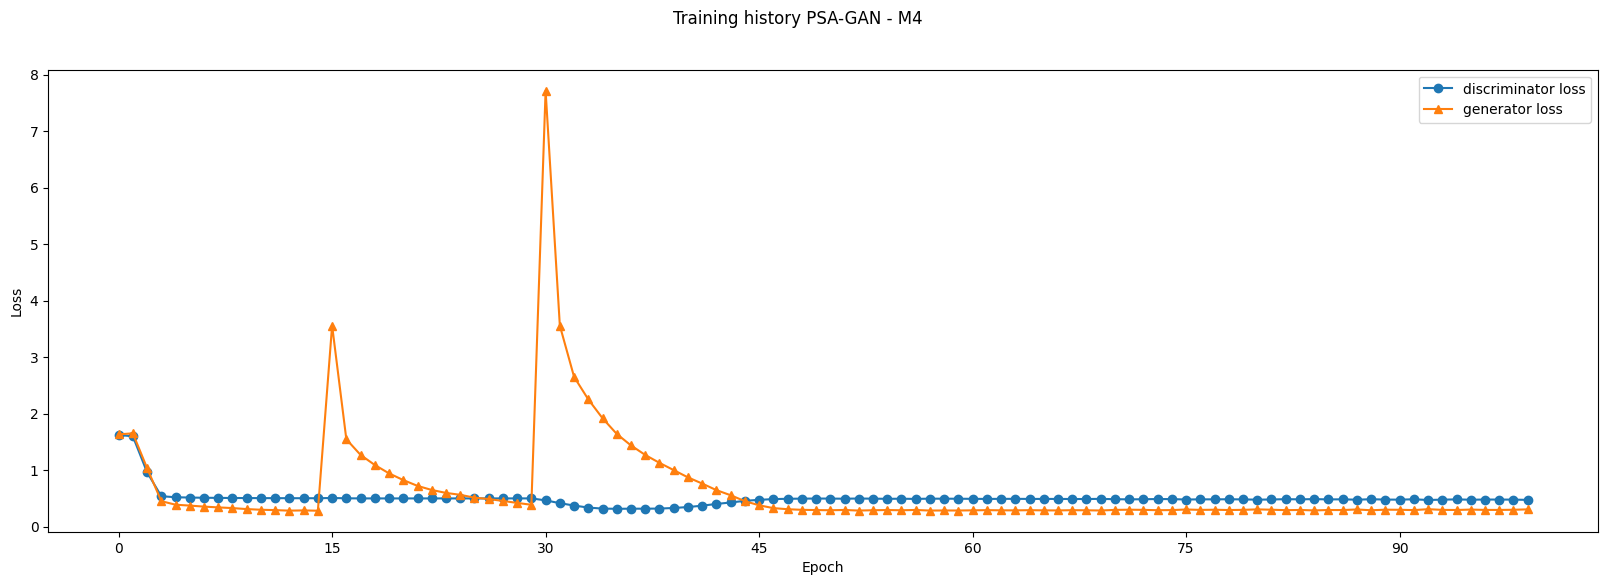

In [10]:

utils.plot_training_history('PSA-GAN - M4',d_losses, g_losses)


In [11]:
load=True

if(load):
    G = torch.load(path+'/generator_model.pt')
    D = torch.load(path+'/discriminator_model.pt')

Prediction on the train set

generated_series:  torch.Size([379, 256, 1])


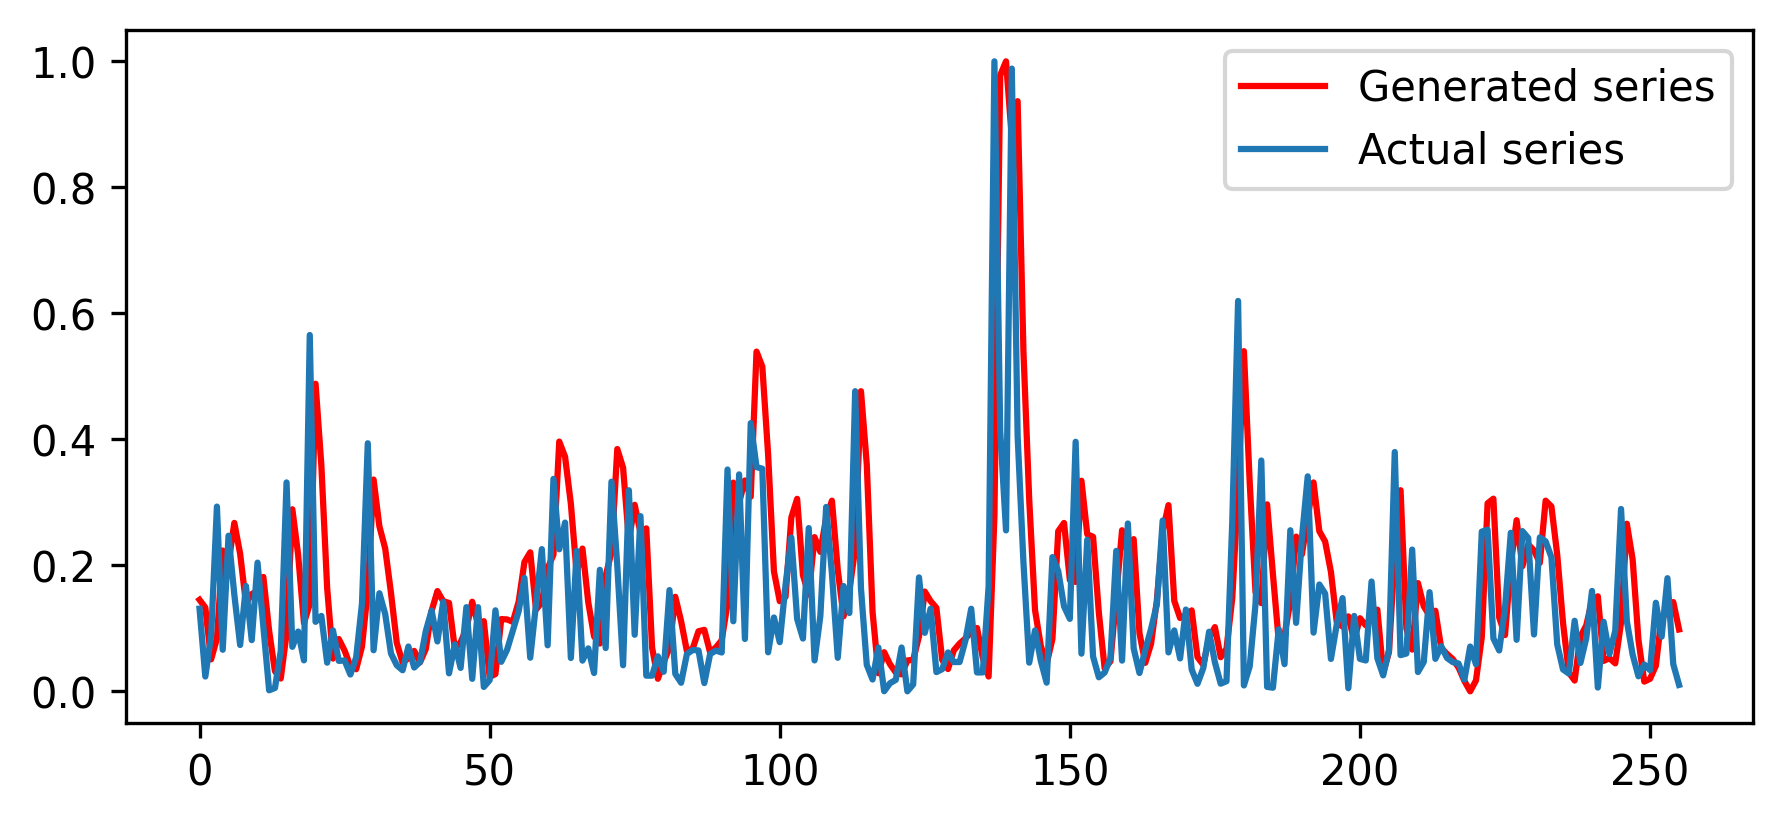

Parameter containing:
tensor([0.0343], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0016], device='cuda:0', requires_grad=True)


In [22]:
t = train_set[len(trainX):len(trainX)+seq_length]

with torch.no_grad():
    
    generated_series = G(trainX[len(trainX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()



generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)



plt.figure(figsize=(7, 3), dpi=300)


plt.plot(generated_series[batch_size-1], label='Generated series', color="red")
plt.plot(aux, label='Actual series', )


plt.legend()
plt.show()

print(G.main.attn.gamma)
print(G.blocks[0].attn.gamma)

Prediction on the test set  